In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_excel("台中市合併資料2023Q3-2024Q2_2.xlsx")

In [3]:
df.drop_duplicates(subset=["成交編號"], keep="first", inplace=True)

In [4]:
df=df.reset_index(drop=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13870 entries, 0 to 13869
Data columns (total 34 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   成交年月    13870 non-null  int64         
 1   開價年月    13870 non-null  int64         
 2   成交日期    13870 non-null  datetime64[ns]
 3   開價日期    13870 non-null  datetime64[ns]
 4   成交編號    13870 non-null  object        
 5   開價編號    13870 non-null  int64         
 6   縣市      13870 non-null  object        
 7   鄉鎮市區    13870 non-null  object        
 8   成交路名    13870 non-null  object        
 9   開價路名    13870 non-null  object        
 10  社區名稱    13870 non-null  object        
 11  成交門牌    13870 non-null  object        
 12  開價段     0 non-null      float64       
 13  成交總樓層   13870 non-null  int64         
 14  開價總樓層   13833 non-null  float64       
 15  成交移轉層次  13870 non-null  object        
 16  開價移轉層次  12501 non-null  float64       
 17  建物型態    13870 non-null  object        
 18  建材    

In [6]:
df=df[["開價年月","縣市","鄉鎮市區","社區名稱","開價總樓層","開價移轉層次","建物型態","開價屋齡","開價面積",'開價總價','開價單價',"房型","車位類別","有無管理組織","銷售天期","建材","成交單價","成交總價","折價率"]]

In [7]:
df=df[df["開價移轉層次"]>=2]

In [8]:
df.isnull().sum()

開價年月         0
縣市           0
鄉鎮市區         0
社區名稱         0
開價總樓層        1
開價移轉層次       0
建物型態         0
開價屋齡         0
開價面積         0
開價總價         0
開價單價         0
房型           0
車位類別      3910
有無管理組織       0
銷售天期         0
建材           0
成交單價         0
成交總價         0
折價率          0
dtype: int64

In [9]:
df["建材"].value_counts()

建材
鋼筋混凝土造                 9963
鋼骨鋼筋混凝土造                208
鋼骨造                      58
ＲＣ造                      47
加強磚造                     34
鋼骨混凝土造                   14
鋼筋混凝土加強磚造                11
ＲＣ造、鋼骨造                   3
見其他登記事項                   3
鋼骨鋼筋混凝土造、鋼筋混凝土造           3
鐵筋加強磚                     3
鐵筋加強磚造                    3
加強磚造、水泥平頂、磨石地床            2
ＲＣ鋼筋混凝土造                  2
磚造                        2
ＲＣ造．鋼骨造                   1
鋼造                        1
鋼骨鋼筋混凝土造，鋼筋混凝土造，鋼骨造       1
Name: count, dtype: int64

In [10]:
df.loc[~df['建材'].isin(['鋼筋混凝土造','鋼骨鋼筋混凝土造','鋼骨造','ＲＣ造','其他']), '建材'] = '其他'

In [11]:
df["建材"]=df["建材"].fillna("鋼筋混凝土造")

In [12]:
#缺失值處理，idea 就 缺值我填無，到時建模再用label encoding 處理
df["車位類別"]=df["車位類別"].fillna("無車位")

In [13]:
df=df.dropna()

In [14]:
#極端值處理 我們處理格局 總價 單價 面積
#df.describe()

for outlier in ["開價面積","開價總價","開價單價","房型","成交總價","成交單價","折價率","開價屋齡"]:
    stat = df[outlier].describe()
    IQR = stat["75%"] - stat["25%"]
    upper_limit = stat["75%"] + 1.5 * IQR
    lower_limit = stat["25%"] - 1.5 * IQR
    df = df[(df[outlier] <= upper_limit) & (df[outlier] >= lower_limit)]


In [15]:
#把開價年月轉成開價季資料
df["開價年月"]=df["開價年月"].astype("string")
def transfer_to_season(date):
    year = date[:4]
    month = date[4:]
    
    if month in ["01", "02", "03"]:
        return year + "Q1"
    elif month in ["04", "05", "06"]:
        return year + "Q2"
    elif month in ["07", "08", "09"]:
        return year + "Q3"
    elif month in ["10", "11", "12"]:
        return year + "Q4"
    else:
        return "Invalid Date"


df["開價季度"] = df["開價年月"].apply(transfer_to_season)

In [16]:
df=df[df["開價季度"]!='2024Q3']
df=df[df["開價季度"]!='2023Q2']

In [17]:
#做完視覺化後，我們做一下特徵工程

#先處理label encoding
#我們思考一下哪些類別是有排名依序的
#車位種類?  建材? 我們嘗試用車位和建材型態做label encoding
car_dict={'無車位':0,'其他':1,'塔式車位':2,'升降機械':3,'升降平面':4,'坡道機械':5,'坡道平面':6,'一樓平面':7}
material_dict={"其他":0,"ＲＣ造":1,"鋼骨造":2,"鋼骨鋼筋混凝土造":3,"鋼筋混凝土造":4}
type_dict={"公寓(5樓含以下無電梯)":0,"華廈(10層含以下有電梯)":1,"住宅大樓(11層含以上有電梯)":2,"透天厝":3}

In [18]:
df["車位類別"]=df["車位類別"].map(car_dict)
df["建材"]=df["建材"].map(material_dict)
df["建物型態"]=df["建物型態"].map(type_dict)

In [19]:
from sklearn.preprocessing import LabelEncoder

# 創建LabelEncoder物件
le = LabelEncoder()

# 使用fit_transform方法進行編碼
df["鄉鎮市區"] = le.fit_transform(df["鄉鎮市區"])

In [20]:
#接下來處理one hot encoding
df=pd.get_dummies(df,columns=["有無管理組織","開價季度"],drop_first=True,dtype=int)

In [21]:
df=df.drop(["縣市","社區名稱","開價年月"],axis=1)

In [22]:
df.reset_index(drop=True,inplace=True)

In [23]:
df["開價移轉層次"]=df["開價移轉層次"].astype(int)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8600 entries, 0 to 8599
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   鄉鎮市區         8600 non-null   int32  
 1   開價總樓層        8600 non-null   float64
 2   開價移轉層次       8600 non-null   int32  
 3   建物型態         8600 non-null   int64  
 4   開價屋齡         8600 non-null   float64
 5   開價面積         8600 non-null   float64
 6   開價總價         8600 non-null   int64  
 7   開價單價         8600 non-null   float64
 8   房型           8600 non-null   int64  
 9   車位類別         8600 non-null   int64  
 10  銷售天期         8600 non-null   int64  
 11  建材           8600 non-null   int64  
 12  成交單價         8600 non-null   float64
 13  成交總價         8600 non-null   float64
 14  折價率          8600 non-null   float64
 15  有無管理組織_無     8600 non-null   int32  
 16  開價季度_2023Q4  8600 non-null   int32  
 17  開價季度_2024Q1  8600 non-null   int32  
 18  開價季度_2024Q2  8600 non-null   int32  
dtypes: flo

In [25]:
#基本上我們用幾個監督學習的model like linear regression random forest svm and xgbregressor
#百套件箱裝一樁
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [26]:
X= df.drop(["成交單價","成交總價","折價率"],axis=1)
y= df["成交總價"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=101)

In [28]:
pipeline_lr=Pipeline([("scalar1",StandardScaler()),
                     ("lr_classifier",LinearRegression())])

pipeline_dt=Pipeline([("scalar2",StandardScaler()),
                     ("dt_classifier",DecisionTreeRegressor())])

pipeline_rf=Pipeline([("scalar3",StandardScaler()),
                     ("rf_classifier",RandomForestRegressor())])


pipeline_kn=Pipeline([("scalar4",StandardScaler()),
                     ("kn_classifier",KNeighborsRegressor())])


pipeline_xgb=Pipeline([("scalar5",StandardScaler()),
                     ("xgb_classifier",XGBRegressor())])


pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb]


pipe_dict = {0: "LinearRegression", 1: "DecisionTree", 2: "RandomForest",3: "KNeighbors", 4: "XGBRegressor"}
#fit model
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [29]:
cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=10)
    cv_results_rms.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

LinearRegression: -49.294171 
DecisionTree: -68.988383 
RandomForest: -50.047421 
KNeighbors: -114.036143 
XGBRegressor: -51.625942 


In [30]:
#從結果我們預測RandomForest
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

In [31]:
# #用 Random forest regressor 做一做
# parameters = {
#     'n_estimators': [100, 150, 200, 250, 300],
#     'max_depth': [1,2,3,4],
# }
# regr = RandomForestRegressor(random_state=0)

# clf = GridSearchCV(regr, parameters)
# clf.fit(X_train, y_train)

In [32]:
# clf.best_estimator_

In [33]:
lr_model=LinearRegression()
lr_model.fit(X_train,y_train)
y_pred=lr_model.predict(X_test)

In [34]:
print("R^2:",metrics.r2_score(y_test, y_pred))
print("MAE:",metrics.mean_absolute_error(y_test, y_pred))
print("MSE:",metrics.mean_squared_error(y_test, y_pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("MAPE",mean_absolute_percentage_error(y_test,y_pred))

R^2: 0.9900369350516036
MAE: 34.6737923533596
MSE: 2198.91504151895
RMSE: 46.892590475670566
MAPE 0.03667898163780142


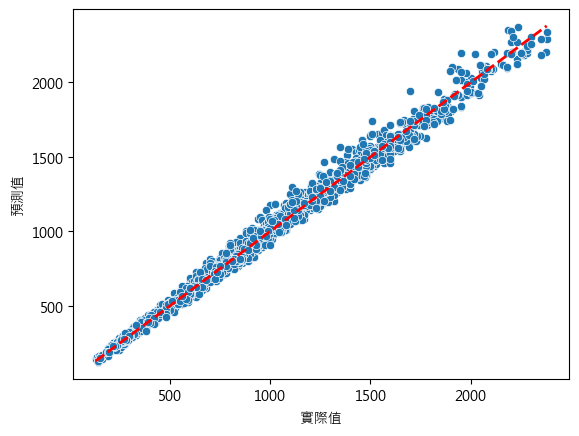

In [35]:
sns.scatterplot(x=y_test,y=y_pred)
sns.set_style("whitegrid", {"font.sans-serif": ['Microsoft JhengHei']})
plt.xlabel('實際值')
plt.ylabel('預測值')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)

In [36]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8600 entries, 0 to 8599
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   鄉鎮市區         8600 non-null   int32  
 1   開價總樓層        8600 non-null   float64
 2   開價移轉層次       8600 non-null   int32  
 3   建物型態         8600 non-null   int64  
 4   開價屋齡         8600 non-null   float64
 5   開價面積         8600 non-null   float64
 6   開價總價         8600 non-null   int64  
 7   開價單價         8600 non-null   float64
 8   房型           8600 non-null   int64  
 9   車位類別         8600 non-null   int64  
 10  銷售天期         8600 non-null   int64  
 11  建材           8600 non-null   int64  
 12  有無管理組織_無     8600 non-null   int32  
 13  開價季度_2023Q4  8600 non-null   int32  
 14  開價季度_2024Q1  8600 non-null   int32  
 15  開價季度_2024Q2  8600 non-null   int32  
dtypes: float64(4), int32(6), int64(6)
memory usage: 873.6 KB


In [40]:
test=np.array([3,12,8,2,15,40,1600,40,4,6,50,6,1,0,0,1])
test=test.reshape(-1,1)
test=test.reshape(1,16)
case=lr_model.predict(test)
rmse=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
mape=mean_absolute_percentage_error(y_test,y_pred)
print(f"開價1600萬，成交價預測{case.item():.2f}萬,折價率預測為{(1-case.item()/1600)*100:.2f}%")
print(f"價格誤差範圍介於{(case.item()-rmse):.2f},{(case.item()+rmse):.2f}")
print(f"折價率誤差範圍介於{(1-(case.item()-rmse)/1600)*100:.2f},{(1-(case.item()+rmse)/1600)*100:.2f}")
print("折價率誤差正負2.92%")
print(f"預測價格實際價格平均會差{round(mape*100,2)}%")

開價1600萬，成交價預測1481.69萬,折價率預測為7.39%
價格誤差範圍介於1434.79,1528.58
折價率誤差範圍介於10.33,4.46
折價率誤差正負2.92%
預測價格實際價格平均會差3.67%


In [ ]:
#不特徵縮放 進行 random forest
# rf_model=RandomForestRegressor()



In [ ]:
# from sklearn.model_selection import GridSearchCV

In [ ]:
# parameters = {
#     'n_estimators': [100, 150, 200, 250, 300],
#     'max_depth': [1,2,3,4],
# }
# regr = RandomForestRegressor(random_state=0)

# clf = GridSearchCV(regr, parameters)
# clf.fit(X_train, y_train)

In [ ]:
# y_pred=clf.predict(X_test)

In [ ]:
# print("R^2:",metrics.r2_score(y_test, y_pred))
# print("MAE:",metrics.mean_absolute_error(y_test, y_pred))
# print("MSE:",metrics.mean_squared_error(y_test, y_pred))
# print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("MAPE",mean_absolute_percentage_error(y_test,y_pred))


In [ ]:
# sns.scatterplot(x=y_test,y=y_pred)
# plt.xlabel('實際值')
# plt.ylabel('預測值')
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)

In [ ]:
#進行特徵縮放
# df=df.drop("折價率",axis=1)

In [ ]:
# df=df.drop("成交單價",axis=1)

In [ ]:
# scaler=StandardScaler()
# df=scaler.fit_transform(df)


In [ ]:
# df=pd.DataFrame(df)

In [ ]:
# X=df.drop(11,axis=1)
# y=df[11]

In [ ]:
X_scaler_train, X_scaler_test, y_scaler_train, y_scaler_test = train_test_split(X, y,test_size=0.25, random_state=101)

In [ ]:
# parameters = {
#     'n_estimators': [100,200,300],
#     'max_depth': [1,2,3,4],
# }
# regr = RandomForestRegressor(random_state=0)

# clf2 = GridSearchCV(regr, parameters)
# clf2.fit(X_scaler_train, y_scaler_train)

In [ ]:
# y_pred2=clf2.predict(X_scaler_test)

In [ ]:
# print("R^2:",metrics.r2_score(y_scaler_test, y_pred2))
# print("MAE:",metrics.mean_absolute_error(y_scaler_test, y_pred2))
# print("MSE:",metrics.mean_squared_error(y_scaler_test, y_pred2))
# print("RMSE:",np.sqrt(metrics.mean_squared_error(y_scaler_test, y_pred2)))
# print("MAPE",mean_absolute_percentage_error(y_scaler_test,y_pred2))

In [ ]:
# sns.scatterplot(x=y_scaler_test,y=y_pred2)
# sns.set_style("whitegrid", {"font.sans-serif": ['Microsoft JhengHei']})
# plt.xlabel('實際值')
# plt.ylabel('預測值')
# plt.plot([min(y_scaler_test), max(y_scaler_test)], [min(y_scaler_test), max(y_scaler_test)], linestyle='--', color='red', linewidth=2)

In [ ]:
#用 linear model 做一做
lr_model=LinearRegression()
lr_model.fit(X_scaler_train,y_scaler_train)

In [ ]:
# y_pred3=lr_model.predict(X_scaler_test)

In [ ]:
# print("R^2:",metrics.r2_score(y_scaler_test, y_pred3))
# print("MAE:",metrics.mean_absolute_error(y_scaler_test, y_pred3))
# print("MSE:",metrics.mean_squared_error(y_scaler_test, y_pred3))
# print("RMSE:",np.sqrt(metrics.mean_squared_error(y_scaler_test, y_pred3)))
# print("MAPE",mean_absolute_percentage_error(y_scaler_test,y_pred3))

In [ ]:
# sns.scatterplot(x=y_scaler_test,y=y_pred3)
# sns.set_style("whitegrid", {"font.sans-serif": ['Microsoft JhengHei']})
# plt.xlabel('實際值')
# plt.ylabel('預測值')
# plt.plot([min(y_scaler_test), max(y_scaler_test)], [min(y_scaler_test), max(y_scaler_test)], linestyle='--', color='red', linewidth=2)

In [ ]:
# test=np.array([12,8,2,15,40,40,1600,4,6,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1])
# test=test.reshape(-1,1)
# test=test.reshape(1,26)
# case=lr_model.predict(test)
# rmse=np.sqrt(metrics.mean_squared_error(y_test, y_pred3))
# mape=mean_absolute_percentage_error(y_test,y_pred3)
# print(f"開價1600萬，成交價預測{case.item():.2f}萬,折價率預測為{(1-case.item()/1600)*100:.2f}%")
# print(f"誤差範圍介於{(case.item()-rmse):.2f},{(case.item()+rmse):.2f}")
# print(f"折價率誤差範圍介於{(1-(case.item()-rmse)/1600)*100:.2f},{(1-(case.item()+rmse)/1600)*100:.2f}")
# print("誤差正負3.17%")
# print("預測價格實際價格平均會差3.88%")


In [ ]:
#試試看作特徵縮放
# scaler=StandardScaler()

In [ ]:
# X_scaler_train2=scaler.fit_transform(X_scaler_train)

In [ ]:
# X_scaler_test2=scaler.fit_transform(X_scaler_test)

In [ ]:
# lr_model=LinearRegression()
# lr_model.fit(X_scaler_train2,y_train)




In [ ]:
# scaler=MinMaxScaler()
# df=scaler.fit_transform(df)
# df = pd.DataFrame(df)
# X=df.drop(12,axis=1)
# y=df[12]
# X_scaler_train, X_scaler_test, y_scaler_train, y_scaler_test = train_test_split(X, y,test_size=0.25, random_state=101)
# LR_model=LinearRegression()
# LR_model.fit(X_scaler_train,y_scaler_train)
# y_scaler_pred=LR_model.predict(X_scaler_test)
# print("R^2:",metrics.r2_score(y_scaler_test, y_scaler_pred))
# print("MAE:",metrics.mean_absolute_error(y_scaler_test, y_scaler_pred))
# print("MSE:",metrics.mean_squared_error(y_scaler_test, y_scaler_pred))
# print("RMSE:",np.sqrt(metrics.mean_squared_error(y_scaler_test, y_scaler_pred)))
# print("MAPE",mean_absolute_percentage_error(y_scaler_test,y_scaler_pred))
# sns.scatterplot(x=y_scaler_test,y=y_scaler_pred)
# plt.xlabel('實際值')
# plt.ylabel('預測值')
# plt.plot([min(y_scaler_test), max(y_scaler_test)], [min(y_scaler_test), max(y_scaler_test)], linestyle='--', color='red', linewidth=2)